# Mutation analysis, COSMIC lookup

In [2]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git
# try:
#     import gget
# except ImportError:
#     print("gget not found, installing...")
#     !pip install -U -q gget

In [3]:
import os
import subprocess
import shutil
import anndata as ad
import pandas as pd
import gget
import varseek as vk
from varseek.utils import convert_mutation_cds_locations_to_cdna

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

### File path definitions and imports

In [ ]:
n = 3

vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out")
adata_path = os.path.join(vk_count_out_dir, "adata_cleaned.h5ad")

out_dir = os.path.join(vk_count_out_dir, "analysis", "cosmic_lookup")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")
cosmic_tsv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37.tsv")
sequences_cds = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cds.all.fa")
sequences_cdna = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")

In [11]:
# download cosmic and cdna
if not os.path.exists(sequences_cdna):
    print("Downloading cDNA")
    reference_cdna_dir = os.path.dirname(sequences_cdna) if os.path.dirname(sequences_cdna) else "."
    gget_ref_command = ["gget", "ref", "-w", "cdna", "-r", "93", "--out_dir", reference_cdna_dir, "-d", "human_grch37"]
    subprocess.run(gget_ref_command, check=True)
    subprocess.run(["gunzip", f"{sequences_cdna}.gz"], check=True)
if not os.path.exists(sequences_cds):
    print("Downloading CDS")
    reference_cds_dir = os.path.dirname(sequences_cds) if os.path.dirname(sequences_cds) else "."
    gget_ref_command = ["gget", "ref", "-w", "cds", "-r", "93", "--out_dir", reference_cds_dir, "-d", "human_grch37"]
    subprocess.run(gget_ref_command, check=True)
    subprocess.run(["gunzip", f"{sequences_cds}.gz"], check=True)

if not os.path.exists(cosmic_csv) or not os.path.exists(cosmic_tsv):
    print("Downloading COSMIC")
    reference_out_dir_cosmic = os.path.dirname(os.path.dirname(cosmic_csv))
    gget.cosmic(
        None,
        grch_version=37,
        cosmic_version=101,
        out=reference_out_dir_cosmic,
        mutation_class="cancer",
        download_cosmic=True,
        gget_mutate=True,
    )

cosmic_df = pd.read_csv(cosmic_csv, nrows=2)

if "mutation_cdna" not in cosmic_df.columns:
    print("Converting CDS to cDNA in COSMIC")
    _, _ = convert_mutation_cds_locations_to_cdna(input_csv_path=cosmic_csv, output_csv_path=cosmic_csv, cds_fasta_path=sequences_cds, cdna_fasta_path=sequences_cdna, verbose=True)

cosmic_df = pd.read_csv(cosmic_csv)
if "vcrs_header_cdna" not in cosmic_df.columns:
    cosmic_df["vcrs_header_cdna"] = cosmic_df["seq_ID"] + ":" + cosmic_df["mutation_cdna"]
if "vcrs_header_cds" not in cosmic_df.columns:
    cosmic_df["vcrs_header_cds"] = cosmic_df["seq_ID"] + ":" + cosmic_df["mutation"]
    # cosmic_df.to_csv(cosmic_csv, index=False)

/var/folders/wr/wdr46lxn7fbc_kty6kwbfhxc0000gn/T/ipykernel_41147/1136658275.py:34: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_df = pd.read_csv(cosmic_csv)


In [14]:
cosmic_df.head()

,seq_ID,mutation,mutation_aa,GENOMIC_MUTATION_ID,chromosome,strand,mutation_genome,gene_name,mutation_id,mutation_cdna,header,vcrs_header_cdna,vcrs_header_cds
0,ENST00000396153,c.1468C>T,p.Q490*,COSV105286190,1,-,g.51001067G>A,FAF1,48293736,c.1920C>T,ENST00000396153:c.1920C>T,ENST00000396153:c.1920C>T,ENST00000396153:c.1468C>T
1,ENST00000445907,c.162C>A,p.L54=,COSV57765075,7,+,g.136699774C>A,CHRM2,60222372,c.690C>A,ENST00000445907:c.690C>A,ENST00000445907:c.690C>A,ENST00000445907:c.162C>A
2,ENST00000445907,c.617A>T,p.Y206F,COSV108138517,7,+,g.136700229A>T,CHRM2,60229878,c.1145A>T,ENST00000445907:c.1145A>T,ENST00000445907:c.1145A>T,ENST00000445907:c.617A>T
3,ENST00000445907,c.93A>T,p.G31=,COSV100282253,7,+,g.136699705A>T,CHRM2,60227007,c.621A>T,ENST00000445907:c.621A>T,ENST00000445907:c.621A>T,ENST00000445907:c.93A>T
4,ENST00000445907,c.956A>C,p.N319T,COSV108138508,7,+,g.136700568A>C,CHRM2,60213402,c.1484A>C,ENST00000445907:c.1484A>C,ENST00000445907:c.1484A>C,ENST00000445907:c.956A>C


In [19]:
cosmic_df_full = pd.read_csv(cosmic_tsv, sep="\t")
cosmic_df_full["mutation_id"] = cosmic_df_full["MUTATION_URL"].str.extract(r"id=(\d+)").astype("int64")
cosmic_df_full.head()

,GENE_NAME,ACCESSION_NUMBER,ONC_TSG,CGC_TIER,MUTATION_URL,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,AA_MUT_START,AA_MUT_STOP,SHARED_AA,GENOMIC_WT_ALLELE_SEQ,GENOMIC_MUT_ALLELE_SEQ,AA_WT_ALLELE_SEQ,AA_MUT_ALLELE_SEQ,Mutation Description CDS,Mutation Description AA,ONTOLOGY_MUTATION_CODE,GENOMIC_MUTATION_ID,Mutation genome position GRCh37,Mutation genome position GRCh38,COSMIC_SAMPLE_TESTED,COSMIC_SAMPLE_MUTATED,DISEASE,WGS_DISEASE,EXAC_AF,EXAC_AFR_AF,EXAC_AMR_AF,EXAC_ADJ_AF,EXAC_EAS_AF,EXAC_FIN_AF,EXAC_NFE_AF,EXAC_SAS_AF,GNOMAD_EXOMES_AF,GNOMAD_EXOMES_AFR_AF,GNOMAD_EXOMES_AMR_AF,GNOMAD_EXOMES_ASJ_AF,GNOMAD_EXOMES_EAS_AF,GNOMAD_EXOMES_FIN_AF,GNOMAD_EXOMES_NFE_AF,GNOMAD_EXOMES_SAS_AF,GNOMAD_GENOMES_AF,GNOMAD_GENOMES_AFR_AF,GNOMAD_GENOMES_AMI_AF,GNOMAD_GENOMES_AMR_AF,GNOMAD_GENOMES_ASJ_AF,GNOMAD_GENOMES_EAS_AF,GNOMAD_GENOMES_FIN_AF,GNOMAD_GENOMES_MID_AF,GNOMAD_GENOMES_NFE_AF,GNOMAD_GENOMES_SAS_AF,CLINVAR_CLNSIG,CLINVAR_TRAIT,GERP++_RS,MIN_SIFT_SCORE,MIN_SIFT_PRED,DNDS_DISEASE_QVAL_SIG,MUTATION_SIGNIFICANCE_TIER,mutation_id
0,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM9691637,c.1468C>T,p.Q490*,490,490,1,G,A,Q,*,Substitution,Substitution - Nonsense,SO:0001587,COSV105286190,1:51001067-51001067,1:50535395-50535395,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.52,1.000,NaN,NaN,Other,48293736
1,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM7986191,c.711G>T,p.W237C,237,237,1,C,A,W,C,Substitution,Substitution - Missense,SO:0001583,COSV100875125,1:51121147-51121147,1:50655475-50655475,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.17,0.000,D,NaN,Other,48304295
2,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM6063740,c.1548C>T,p.R516=,516,516,2,G,A,R,R,Substitution,Substitution - coding silent,SO:1000057,COSV65638235,1:50957420-50957420,1:50491748-50491748,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,Other,48302907
3,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM6657959,c.429del,p.G144Afs*13,144,144,1,T,NaN,G,AGRREMWKTVRS*,Deletion,Deletion - Frameshift,SO:0001589,COSV65641246,1:51210389-51210389,1:50744717-50744717,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,Other,48291600
4,FAF1,ENST00000396153.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM10419714,c.797G>A,p.G266E,266,266,1,C,T,G,E,Substitution,Substitution - Missense,SO:0001583,COSV107478819,1:51061836-51061836,1:50596164-50596164,49031,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.64,0.248,T,NaN,Other,48301048


### Load in adata.var and merge in cosmic data

In [36]:
adata = ad.read_h5ad(adata_path)

adata.var.rename(columns={"vcrs_header": "vcrs_header_cdna"}, inplace=True)

# keep only the top n variants
top_vcrs = adata.var["vcrs_count"].nlargest(n).index
adata = adata[:, top_vcrs].copy()
adata.var = adata.var.merge(cosmic_df[["vcrs_header_cdna", "mutation_id"]], on="vcrs_header_cdna", how="left", suffixes=("_original", ""))
adata.var = adata.var.merge(cosmic_df_full, on="mutation_id", how="left", suffixes=("_original", ""))

adata.var.head()

,vcrs_id,vcrs_header_cdna,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,variant_source,vcrs_count,vcrs_detected,number_obs,mutation_id,GENE_NAME,ACCESSION_NUMBER,ONC_TSG,CGC_TIER,MUTATION_URL,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,AA_MUT_START,AA_MUT_STOP,SHARED_AA,GENOMIC_WT_ALLELE_SEQ,GENOMIC_MUT_ALLELE_SEQ,AA_WT_ALLELE_SEQ,AA_MUT_ALLELE_SEQ,Mutation Description CDS,Mutation Description AA,ONTOLOGY_MUTATION_CODE,GENOMIC_MUTATION_ID,Mutation genome position GRCh37,Mutation genome position GRCh38,COSMIC_SAMPLE_TESTED,COSMIC_SAMPLE_MUTATED,DISEASE,WGS_DISEASE,EXAC_AF,EXAC_AFR_AF,EXAC_AMR_AF,EXAC_ADJ_AF,EXAC_EAS_AF,EXAC_FIN_AF,EXAC_NFE_AF,EXAC_SAS_AF,GNOMAD_EXOMES_AF,GNOMAD_EXOMES_AFR_AF,GNOMAD_EXOMES_AMR_AF,GNOMAD_EXOMES_ASJ_AF,GNOMAD_EXOMES_EAS_AF,GNOMAD_EXOMES_FIN_AF,GNOMAD_EXOMES_NFE_AF,GNOMAD_EXOMES_SAS_AF,GNOMAD_GENOMES_AF,GNOMAD_GENOMES_AFR_AF,GNOMAD_GENOMES_AMI_AF,GNOMAD_GENOMES_AMR_AF,GNOMAD_GENOMES_ASJ_AF,GNOMAD_GENOMES_EAS_AF,GNOMAD_GENOMES_FIN_AF,GNOMAD_GENOMES_MID_AF,GNOMAD_GENOMES_NFE_AF,GNOMAD_GENOMES_SAS_AF,CLINVAR_CLNSIG,CLINVAR_TRAIT,GERP++_RS,MIN_SIFT_SCORE,MIN_SIFT_PRED,DNDS_DISEASE_QVAL_SIG,MUTATION_SIGNIFICANCE_TIER
0,ENST00000398606:c.562A>G,ENST00000398606:c.562A>G,ENST00000398606,c.562A>G,562,A>G,562.0,562.0,transcriptome,12986,True,1,48379894.0,GSTP1,ENST00000398606.3,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3752683,c.313A>G,p.I105V,105.0,105.0,2.0,A,G,I,V,Substitution,Substitution - Missense,SO:0001583,COSV66992376,11:67352689-67352689,11:67585218-67585218,49959.0,20.0,soft_tissue/gastrointestinal_stromal_tumour/NS...,soft_tissue/rhabdomyosarcoma/embryonal=5/82=6.1%,0.3318,0.4442,0.5351,0.3335,0.1807,0.2749,0.3191,0.2887,0.3386,0.4476,0.5186,0.2128,0.1773,0.271,0.3326,0.2871,0.3599,0.4427,0.3783,0.4202,0.2119,0.1804,0.2627,0.2563,0.3394,0.2692,Benign&not provided&Benign,Abnormality of immune system physiology&Neopla...,-1.16,1.0,T,NaN,Other
1,ENST00000449260:c.1988C>T,ENST00000449260:c.1988C>T,ENST00000449260,c.1988C>T,1988,C>T,1988.0,1988.0,transcriptome,12022,True,1,60961346.0,PMEL,ENST00000449260.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3998885,c.1977C>T,p.N659=,659.0,659.0,2.0,G,A,N,N,Substitution,Substitution - coding silent,SO:1000057,COSV59384225,12:56348028-56348028,12:55954244-55954244,49031.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Other
2,ENST00000398606:c.804T>C,ENST00000398606:c.804T>C,ENST00000398606,c.804T>C,804,T>C,804.0,804.0,transcriptome,10739,True,1,48379878.0,GSTP1,ENST00000398606.3,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3752684,c.555T>C,p.S185=,185.0,185.0,2.0,T,C,S,S,Substitution,Substitution - coding silent,SO:1000057,COSV66992478,11:67353970-67353970,11:67586499-67586499,49031.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Other
3,ENST00000343262:c.156C>T,ENST00000343262:c.156C>T,ENST00000343262,c.156C>T,156,C>T,156.0,156.0,transcriptome,4695,True,1,31955826.0,RPS2,ENST00000343262.4,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3749345,c.99C>T,p.I33=,33.0,33.0,1.0,G,A,I,I,Substitution,Substitution - coding silent,SO:1000057,COSV51909983,16:2014528-2014528,16:1964527-1964527,49031.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Other
4,ENST00000314138:c.730C>T,ENST00000314138:c.730C>T,ENST00000314138,c.730C>T,730,C>T,730.0,730.0,transcriptome,4448,True,1,27174757.0,RPL27A,ENST00000314138.6,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM6310509,c.327C>T,p.Y109=,109.0,109.0,1.0,C,T,Y,Y,Substitution,Substitution - coding silent,SO:1000057,COSV58484229,11:8707233-8707233,11:8685686-8685686,49031.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [37]:
variant_id_column = "vcrs_header_with_gene_name" if "vcrs_header_with_gene_name" in adata.var.columns else "vcrs_id"
adata.var["variant_id_first"] = adata.var[variant_id_column].str.split(";").str[0]  # take the first variant header of the merged variant headers (they're often splice isoforms anyways)

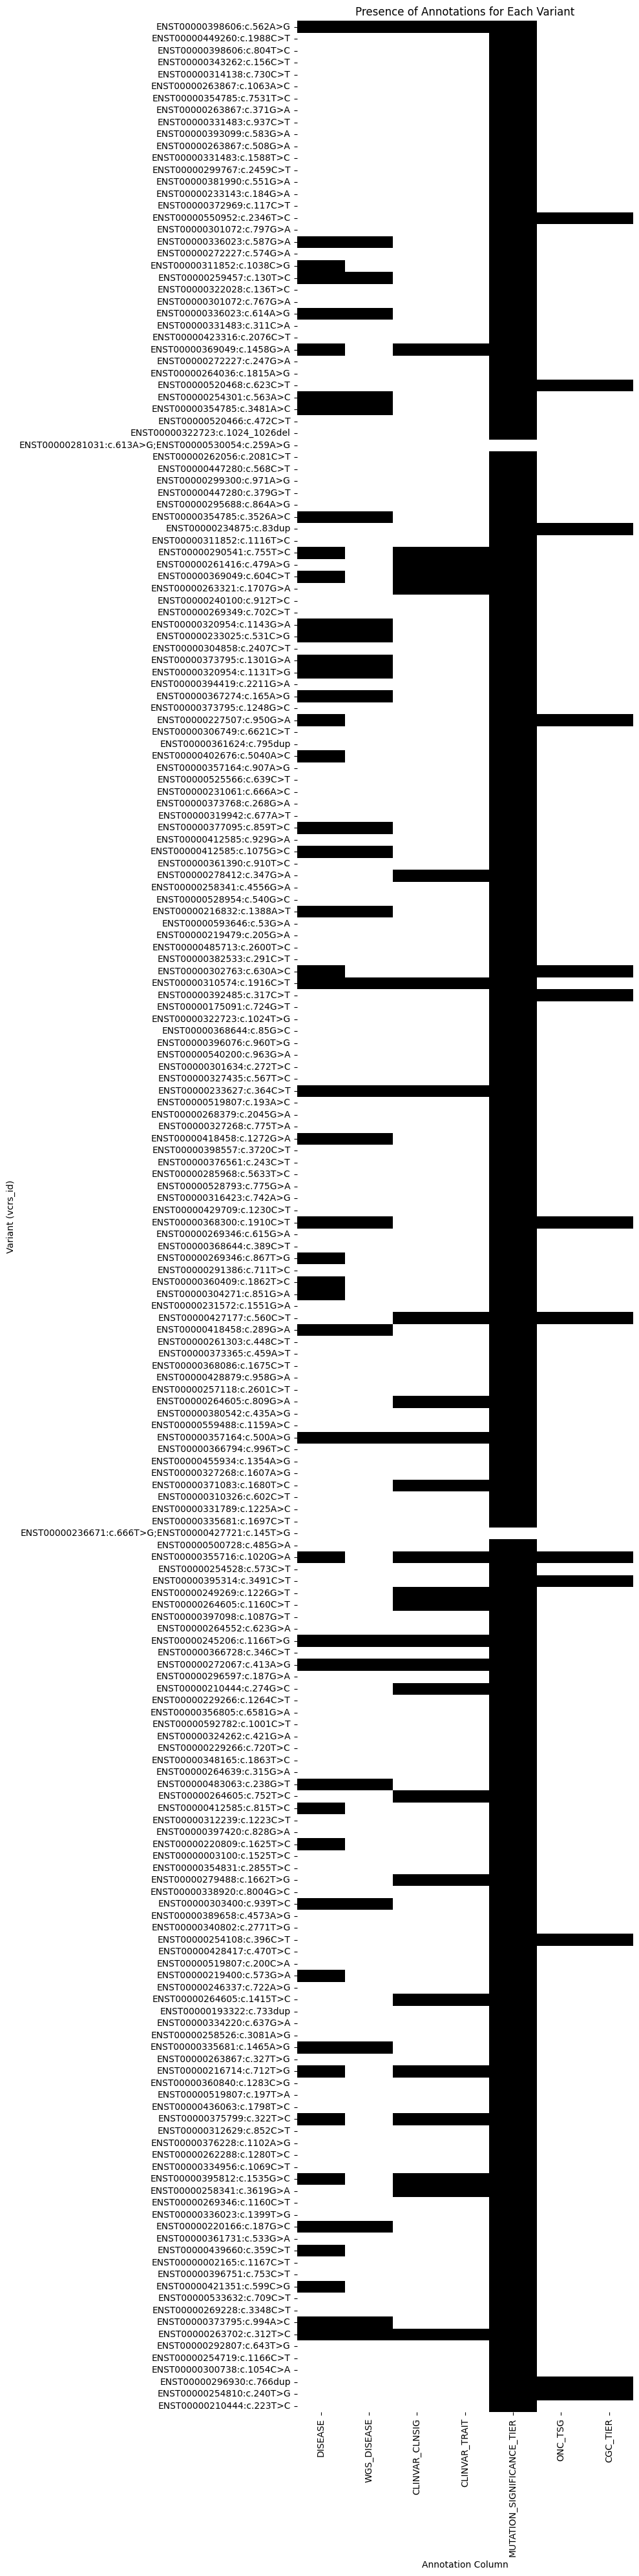

In [38]:
# Columns to check
cols_to_check = [
    "DISEASE", "WGS_DISEASE", "CLINVAR_CLNSIG", "CLINVAR_TRAIT",
    "MUTATION_SIGNIFICANCE_TIER", "ONC_TSG", "CGC_TIER"
]

# Create binary matrix: 1 if value is not null/empty, 0 otherwise
notna_mask = adata.var[cols_to_check].notna()
not_empty_mask = adata.var[cols_to_check].applymap(str).applymap(str.strip).ne("")
presence_matrix = (notna_mask & not_empty_mask).astype(int)
presence_matrix[variant_id_column] = adata.var[variant_id_column]
presence_matrix.set_index(variant_id_column, inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, max(6, 0.2 * len(presence_matrix))))
sns.heatmap(presence_matrix, cmap="Greys", cbar=False)
plt.xlabel("Annotation Column")
plt.ylabel(f"Variant ({variant_id_column})")
plt.title("Presence of Annotations for Each Variant")
plt.tight_layout()
plt.show()

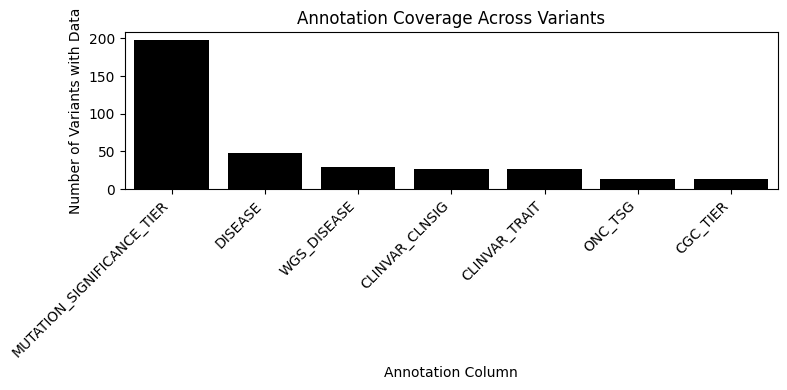

In [39]:
# Sum over rows to get count of non-empty entries per column
annotation_counts = presence_matrix.sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, color="black")
plt.ylabel("Number of Variants with Data")
plt.xlabel("Annotation Column")
plt.title("Annotation Coverage Across Variants")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [55]:
adata.var.head()

,vcrs_id,vcrs_header_cdna,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,variant_source,vcrs_count,vcrs_detected,number_obs,mutation_id,GENE_NAME,ACCESSION_NUMBER,ONC_TSG,CGC_TIER,MUTATION_URL,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,AA_MUT_START,AA_MUT_STOP,SHARED_AA,GENOMIC_WT_ALLELE_SEQ,GENOMIC_MUT_ALLELE_SEQ,AA_WT_ALLELE_SEQ,AA_MUT_ALLELE_SEQ,Mutation Description CDS,Mutation Description AA,ONTOLOGY_MUTATION_CODE,GENOMIC_MUTATION_ID,Mutation genome position GRCh37,Mutation genome position GRCh38,COSMIC_SAMPLE_TESTED,COSMIC_SAMPLE_MUTATED,DISEASE,WGS_DISEASE,EXAC_AF,EXAC_AFR_AF,EXAC_AMR_AF,EXAC_ADJ_AF,EXAC_EAS_AF,EXAC_FIN_AF,EXAC_NFE_AF,EXAC_SAS_AF,GNOMAD_EXOMES_AF,GNOMAD_EXOMES_AFR_AF,GNOMAD_EXOMES_AMR_AF,GNOMAD_EXOMES_ASJ_AF,GNOMAD_EXOMES_EAS_AF,GNOMAD_EXOMES_FIN_AF,GNOMAD_EXOMES_NFE_AF,GNOMAD_EXOMES_SAS_AF,GNOMAD_GENOMES_AF,GNOMAD_GENOMES_AFR_AF,GNOMAD_GENOMES_AMI_AF,GNOMAD_GENOMES_AMR_AF,GNOMAD_GENOMES_ASJ_AF,GNOMAD_GENOMES_EAS_AF,GNOMAD_GENOMES_FIN_AF,GNOMAD_GENOMES_MID_AF,GNOMAD_GENOMES_NFE_AF,GNOMAD_GENOMES_SAS_AF,CLINVAR_CLNSIG,CLINVAR_TRAIT,GERP++_RS,MIN_SIFT_SCORE,MIN_SIFT_PRED,DNDS_DISEASE_QVAL_SIG,MUTATION_SIGNIFICANCE_TIER,variant_id_first
0,ENST00000398606:c.562A>G,ENST00000398606:c.562A>G,ENST00000398606,c.562A>G,562,A>G,562.0,562.0,transcriptome,12986,True,1,48379894.0,GSTP1,ENST00000398606.3,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3752683,c.313A>G,p.I105V,105.0,105.0,2.0,A,G,I,V,Substitution,Substitution - Missense,SO:0001583,COSV66992376,11:67352689-67352689,11:67585218-67585218,49959.0,20.0,soft_tissue/gastrointestinal_stromal_tumour/NS...,soft_tissue/rhabdomyosarcoma/embryonal=5/82=6.1%,0.3318,0.4442,0.5351,0.3335,0.1807,0.2749,0.3191,0.2887,0.3386,0.4476,0.5186,0.2128,0.1773,0.271,0.3326,0.2871,0.3599,0.4427,0.3783,0.4202,0.2119,0.1804,0.2627,0.2563,0.3394,0.2692,Benign&not provided&Benign,Abnormality of immune system physiology&Neopla...,-1.16,1.0,T,NaN,Other,ENST00000398606:c.562A>G
1,ENST00000449260:c.1988C>T,ENST00000449260:c.1988C>T,ENST00000449260,c.1988C>T,1988,C>T,1988.0,1988.0,transcriptome,12022,True,1,60961346.0,PMEL,ENST00000449260.2,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3998885,c.1977C>T,p.N659=,659.0,659.0,2.0,G,A,N,N,Substitution,Substitution - coding silent,SO:1000057,COSV59384225,12:56348028-56348028,12:55954244-55954244,49031.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Other,ENST00000449260:c.1988C>T
2,ENST00000398606:c.804T>C,ENST00000398606:c.804T>C,ENST00000398606,c.804T>C,804,T>C,804.0,804.0,transcriptome,10739,True,1,48379878.0,GSTP1,ENST00000398606.3,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3752684,c.555T>C,p.S185=,185.0,185.0,2.0,T,C,S,S,Substitution,Substitution - coding silent,SO:1000057,COSV66992478,11:67353970-67353970,11:67586499-67586499,49031.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Other,ENST00000398606:c.804T>C
3,ENST00000343262:c.156C>T,ENST00000343262:c.156C>T,ENST00000343262,c.156C>T,156,C>T,156.0,156.0,transcriptome,4695,True,1,31955826.0,RPS2,ENST00000343262.4,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM3749345,c.99C>T,p.I33=,33.0,33.0,1.0,G,A,I,I,Substitution,Substitution - coding silent,SO:1000057,COSV51909983,16:2014528-2014528,16:1964527-1964527,49031.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Other,ENST00000343262:c.156C>T
4,ENST00000314138:c.730C>T,ENST00000314138:c.730C>T,ENST00000314138,c.730C>T,730,C>T,730.0,730.0,transcriptome,4448,True,1,27174757.0,RPL27A,ENST00000314138.6,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/ov...,COSM6310509,c.327C>T,p.Y109=,109.0,109.0,1.0,C,T,Y,Y,Substitution,Substitution - coding silen

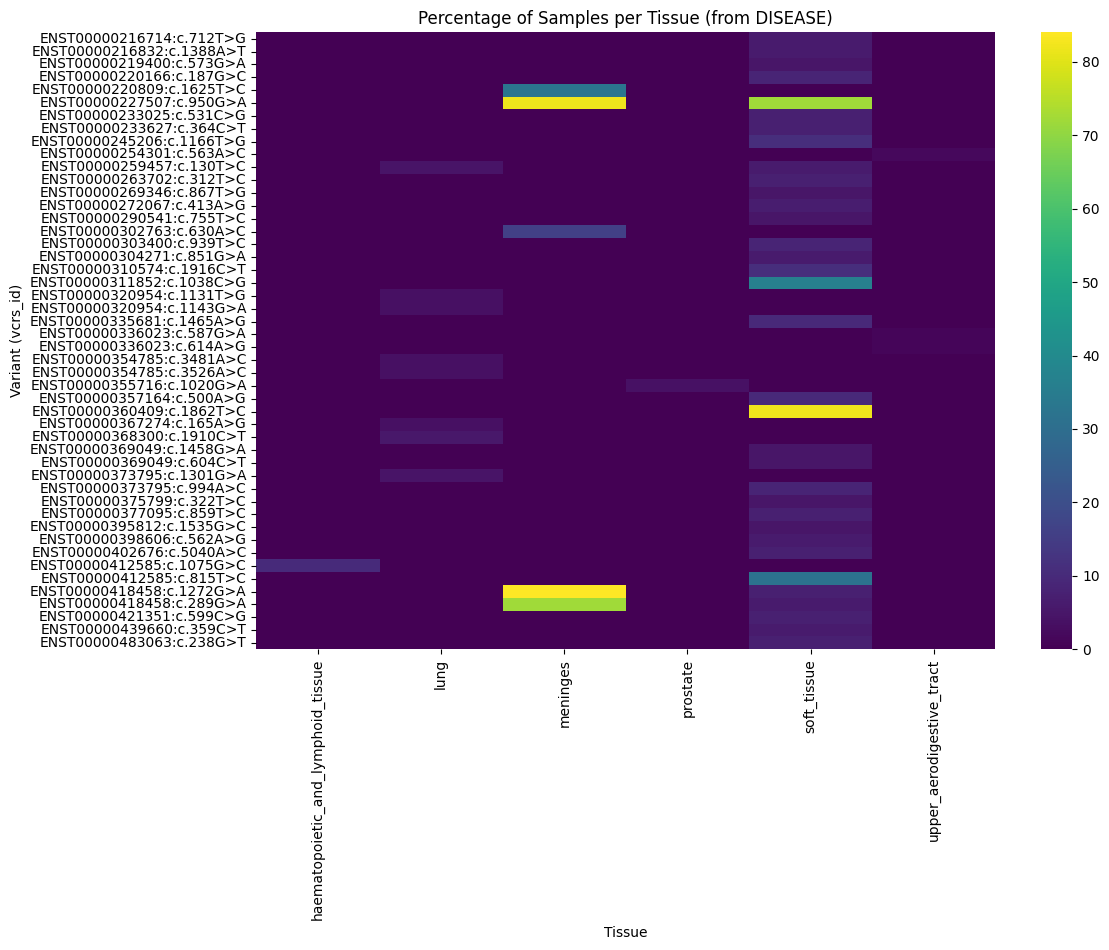

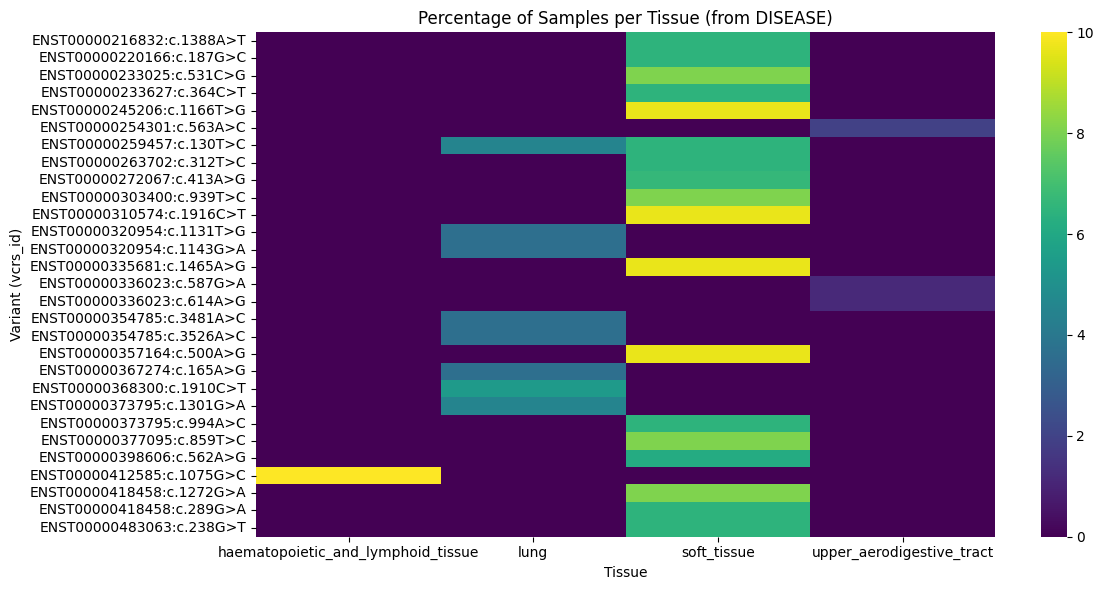

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_disease(df, disease_col="DISEASE", heatmap_col="tissue"):
    """
    Assumes df has columns variant_id_first and DISEASE
    heatmap_col {"tissue", "primary_histology", "sub_histology"}
    """
    df = df.copy()
    
    # Step 1: Split and explode by semicolon
    df[disease_col] = df[disease_col].astype(str).str.strip()
    df["DISEASE_individual"] = df[disease_col].str.split(";")
    df = df[["variant_id_first", "DISEASE_individual"]].explode("DISEASE_individual").dropna()

    # Step 2: Split by equal sign
    df["DISEASE_individual"] = df["DISEASE_individual"].astype(str).where(df["DISEASE_individual"].notna(), None)
    split_cols = df["DISEASE_individual"].str.split("=", expand=True)
    split_cols.columns = ["tissue_group", "fraction_samples", "percentage_samples"]
    df = df.join(split_cols)

    # Step 3: Clean and convert percentage_samples to float
    df["percentage_samples"] = pd.to_numeric(df["percentage_samples"].astype(str).str.rstrip('%'), errors="coerce")
    df = df.dropna(subset=["percentage_samples"])

    # Step 3.5: Split by slash
    df[["tissue", "primary_histology", "sub_histology"]] = df["tissue_group"].str.split("/", expand=True)

    # Step 4: Pivot to wide format
    heatmap_df = df.pivot_table(index="variant_id_first", columns=heatmap_col, values="percentage_samples", aggfunc="max").fillna(0)

    # Step 5: Plot heatmap
    plt.figure(figsize=(12, max(6, 0.2 * len(heatmap_df))))
    sns.heatmap(heatmap_df, cmap="viridis")
    plt.title("Percentage of Samples per Tissue (from DISEASE)")
    plt.xlabel("Tissue")
    plt.ylabel("Variant (vcrs_id)")
    plt.tight_layout()
    plt.show()


plot_disease(adata.var, disease_col="DISEASE", heatmap_col="tissue")
plot_disease(adata.var, disease_col="WGS_DISEASE", heatmap_col="tissue")

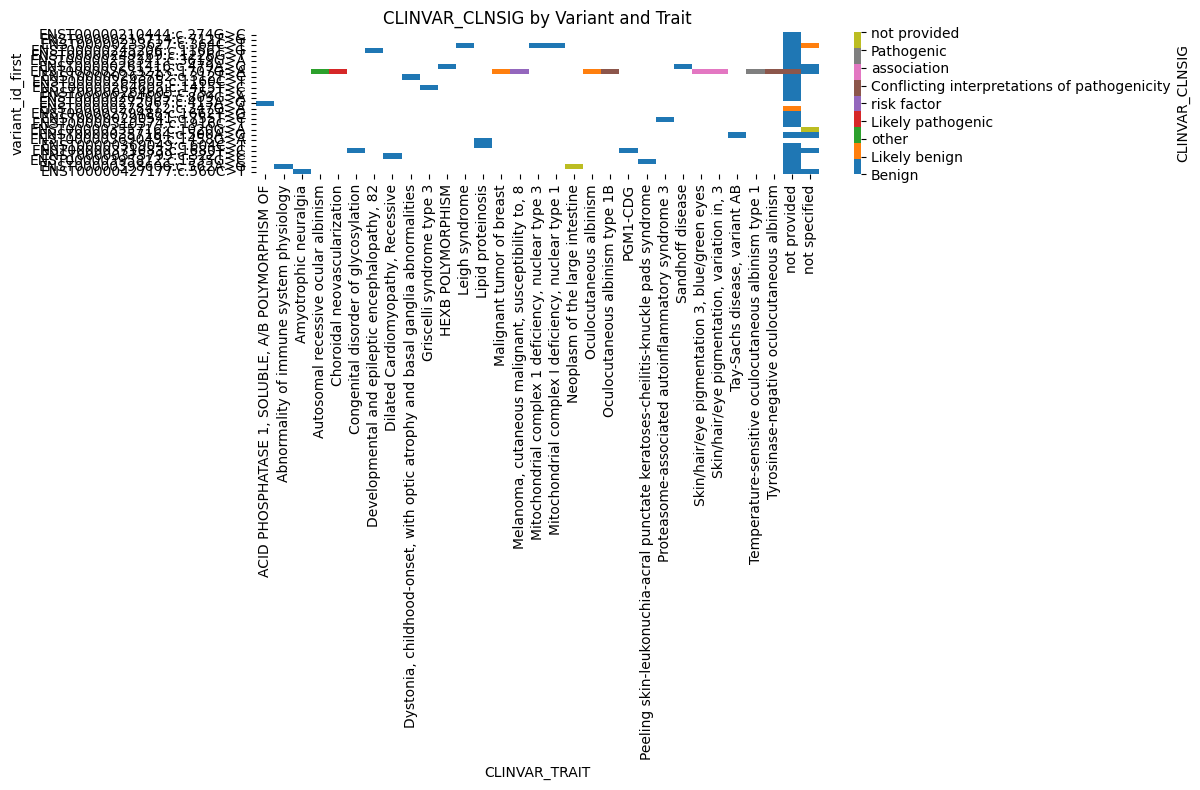

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# cosmic_df_full_tmp = cosmic_df_full[["CLINVAR_CLNSIG"]].dropna().copy()
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split("&")
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# CLINVAR_CLNSIG_unique_values = sorted(cosmic_df_full_tmp['CLINVAR_CLNSIG'].unique().tolist())
# print(len(CLINVAR_CLNSIG_unique_values))
# print(CLINVAR_CLNSIG_unique_values)

CLINVAR_CLNSIG_mapping = {
    'not provided': 'uncertain',  # anything ambiguous will be uncertain
    'other': 'uncertain',
    'Uncertain significance': 'uncertain',
    'Uncertain risk allele': 'uncertain',
    'protective': 'protective',
    'confers sensitivity': 'confers sensitivity',
    'drug response': 'drug response',
    'Affects': 'Affects',  #? affects is too general - consider making association
    'association': 'association',
    'risk factor': 'risk factor',
    'Likely risk allele': 'Likely risk allele',
    'Established risk allele': 'Established risk allele',
    'Benign': 'Benign',  #? lump benign and likely benign together
    'Benign/Likely benign': 'Benign/Likely benign',
    'Likely benign': 'Likely benign',
    'Conflicting interpretations of pathogenicity': 'Conflicting interpretations of pathogenicity',
    'Likely pathogenic': 'Likely pathogenic',
    'Pathogenic/Likely pathogenic': 'Pathogenic/Likely pathogenic',
    'Pathogenic': 'Pathogenic',
}

def plot_clinvar(df):
    # Step 1: Subset and drop NA
    df = df[["variant_id_first", "CLINVAR_CLNSIG", "CLINVAR_TRAIT"]].dropna().copy()

    # Step 2: Split both columns on "&"
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split("&")
    df["CLINVAR_TRAIT"] = df["CLINVAR_TRAIT"].astype(str).str.split("&")

    # Step 3: Explode both
    df = df.explode(["CLINVAR_CLNSIG", "CLINVAR_TRAIT"], ignore_index=True)

    # 3.5. Explode CLINVAR_CLNSIG by semicolon
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
    df = df.explode(["CLINVAR_CLNSIG"], ignore_index=True)

    # Pivot table (with aggregation in case of duplicates)
    pivot_df = df.pivot_table(
        index='variant_id_first',
        columns='CLINVAR_TRAIT',
        values='CLINVAR_CLNSIG',
        aggfunc='first'  # or join as needed
    )

    # Factorize to get numeric codes and mapping
    flat_values = pd.Series(pivot_df.values.ravel())
    codes, unique_vals = pd.factorize(flat_values)

    # Reshape back into the original pivoted shape
    numeric_df = pd.DataFrame(codes.reshape(pivot_df.shape),
                            index=pivot_df.index,
                            columns=pivot_df.columns)

    # Mask NaNs (represented by -1 in factorized array)
    mask = (codes == -1).reshape(pivot_df.shape)

    # Create colormap
    n_categories = len(unique_vals)
    palette = sns.color_palette("tab10", n_colors=n_categories)
    cmap = sns.color_palette(palette, as_cmap=True)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        numeric_df,
        cmap=cmap,
        mask=mask,
        cbar_kws={'ticks': range(n_categories), 'label': 'CLINVAR_CLNSIG'}
    )

    # Add custom tick labels to the colorbar
    colorbar = plt.gca().collections[0].colorbar
    colorbar.set_ticks(range(n_categories))
    colorbar.set_ticklabels(unique_vals)

    plt.title('CLINVAR_CLNSIG by Variant and Trait')
    plt.xlabel('CLINVAR_TRAIT')
    plt.ylabel('variant_id_first')
    plt.tight_layout()
    plt.show()

plot_clinvar(adata.var)

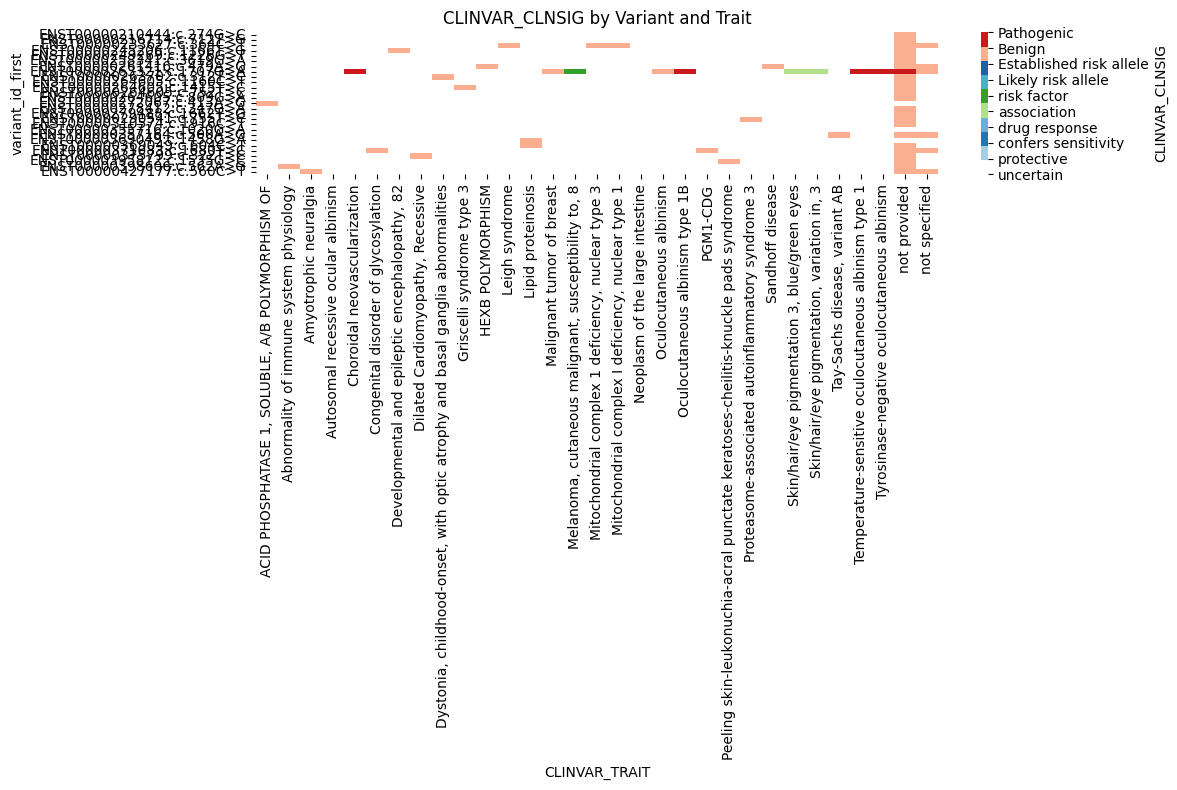

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from matplotlib.colors import ListedColormap

# cosmic_df_full_tmp = cosmic_df_full[["CLINVAR_CLNSIG"]].dropna().copy()
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split("&")
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# CLINVAR_CLNSIG_unique_values = sorted(cosmic_df_full_tmp['CLINVAR_CLNSIG'].unique().tolist())
# print(len(CLINVAR_CLNSIG_unique_values))
# print(CLINVAR_CLNSIG_unique_values)

# Step 0: Ordered mapping
CLINVAR_CLNSIG_mapping = OrderedDict([
    ('not provided', 'uncertain'),  # anything ambiguous will be uncertain
    ('other', 'uncertain'),
    ('Uncertain significance', 'uncertain'),
    ('Uncertain risk allele', 'uncertain'),
    ('protective', 'protective'),
    ('confers sensitivity', 'confers sensitivity'),
    ('drug response', 'drug response'),
    ('Affects', 'association'),
    ('association', 'association'),
    ('risk factor', 'risk factor'),
    ('Likely risk allele', 'Likely risk allele'),
    ('Established risk allele', 'Established risk allele'),
    ('Benign', 'Benign'),
    ('Benign/Likely benign', 'Benign'),
    ('Likely benign', 'Benign'),
    ('Conflicting interpretations of pathogenicity', 'Pathogenic'),   #!!! change some labels, and add to color mapping below
    ('Likely pathogenic', 'Pathogenic'),
    ('Pathogenic/Likely pathogenic', 'Pathogenic'),
    ('Pathogenic', 'Pathogenic'),
])

category_order = list(OrderedDict.fromkeys(CLINVAR_CLNSIG_mapping.values()))  # preserves order
category_colors = {
    'uncertain': '#ffffff',
    'protective': '#a6cee3',
    'confers sensitivity': '#1f78b4',
    'drug response': '#6baed6',
    'association': '#b2df8a',
    'risk factor': '#33a02c',
    'Likely risk allele': '#41b6c4',
    'Established risk allele': '#225ea8',
    'Benign': '#fcae91',
    'Pathogenic': '#cb181d',
}

def plot_clinvar(df):
    # Step 1: Subset and drop NA
    df = df[["variant_id_first", "CLINVAR_CLNSIG", "CLINVAR_TRAIT"]].dropna().copy()

    # Step 2: Split both columns on "&"
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split("&")
    df["CLINVAR_TRAIT"] = df["CLINVAR_TRAIT"].astype(str).str.split("&")

    # Step 3: Explode both
    df = df.explode(["CLINVAR_CLNSIG", "CLINVAR_TRAIT"], ignore_index=True)

    # 3.5. Explode CLINVAR_CLNSIG by semicolon
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
    df = df.explode(["CLINVAR_CLNSIG"], ignore_index=True)
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].map(CLINVAR_CLNSIG_mapping).fillna("uncertain")

    # Pivot table (with aggregation in case of duplicates)
    pivot_df = df.pivot_table(
        index='variant_id_first',
        columns='CLINVAR_TRAIT',
        values='CLINVAR_CLNSIG',
        aggfunc='first'  # or join as needed
    )

    # Map categories to integers in custom order
    category_to_code = {cat: i for i, cat in enumerate(category_order)}
    code_matrix = pivot_df.applymap(lambda x: category_to_code.get(x, -1))
    mask = code_matrix == -1

    # Build colormap
    color_list = [category_colors[c] for c in category_order]
    cmap = ListedColormap(color_list)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        code_matrix,
        cmap=cmap,
        mask=mask,
        cbar_kws={'ticks': range(len(category_order)), 'label': 'CLINVAR_CLNSIG'}
    )

    # Set ordered tick labels
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticks(range(len(category_order)))
    cbar.set_ticklabels(category_order)

    plt.title('CLINVAR_CLNSIG by Variant and Trait')
    plt.xlabel('CLINVAR_TRAIT')
    plt.ylabel('variant_id_first')
    plt.tight_layout()
    plt.show()

plot_clinvar(adata.var)

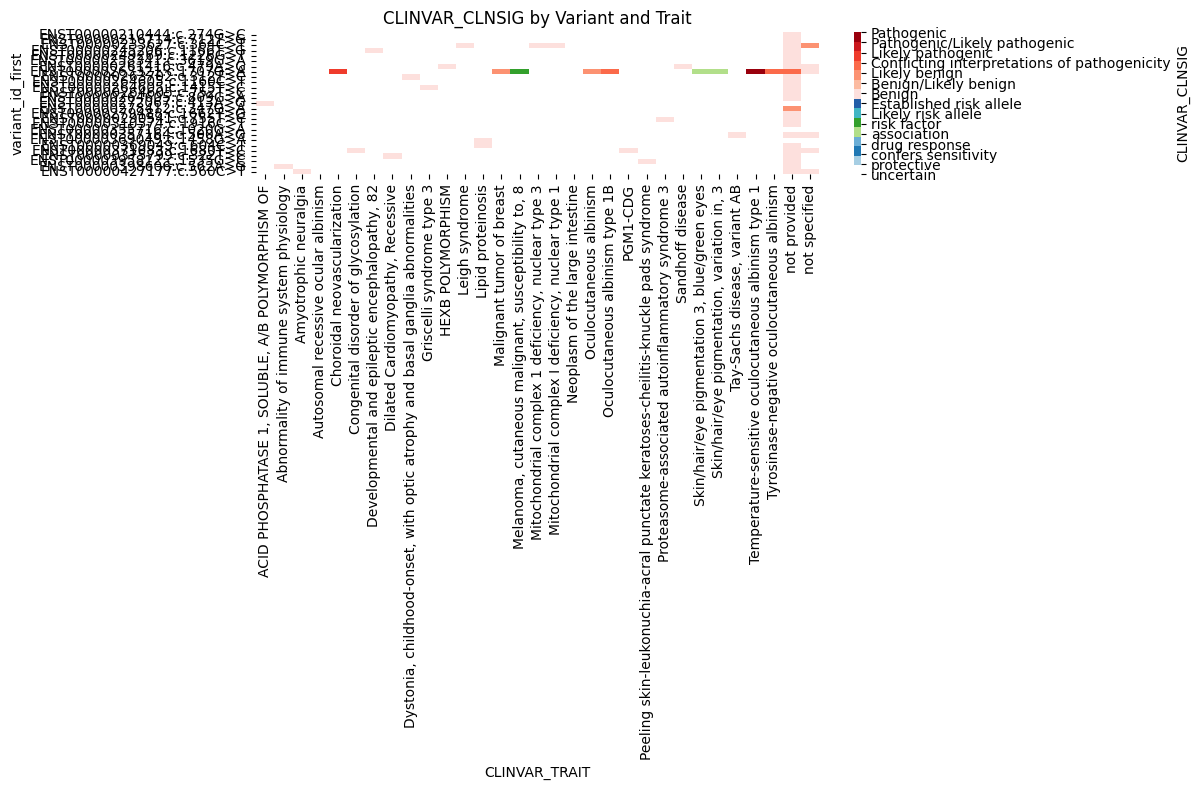

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from matplotlib.colors import ListedColormap

# cosmic_df_full_tmp = cosmic_df_full[["CLINVAR_CLNSIG"]].dropna().copy()
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split("&")
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# cosmic_df_full_tmp["CLINVAR_CLNSIG"] = cosmic_df_full_tmp["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
# cosmic_df_full_tmp = cosmic_df_full_tmp.explode(["CLINVAR_CLNSIG"], ignore_index=True)
# CLINVAR_CLNSIG_unique_values = sorted(cosmic_df_full_tmp['CLINVAR_CLNSIG'].unique().tolist())
# print(len(CLINVAR_CLNSIG_unique_values))
# print(CLINVAR_CLNSIG_unique_values)

# Step 0: Ordered mapping
CLINVAR_CLNSIG_mapping = OrderedDict([
    ('not provided', 'uncertain'),  # anything ambiguous will be uncertain
    ('other', 'uncertain'),
    ('Uncertain significance', 'uncertain'),
    ('Uncertain risk allele', 'uncertain'),
    ('protective', 'protective'),
    ('confers sensitivity', 'confers sensitivity'),
    ('drug response', 'drug response'),
    ('Affects', 'association'),
    ('association', 'association'),
    ('risk factor', 'risk factor'),
    ('Likely risk allele', 'Likely risk allele'),
    ('Established risk allele', 'Established risk allele'),
    ('Benign', 'Benign'),
    ('Benign/Likely benign', 'Benign/Likely benign'),
    ('Likely benign', 'Likely benign'),
    ('Conflicting interpretations of pathogenicity', 'Conflicting interpretations of pathogenicity'),   #!!! change some labels, and add to color mapping below
    ('Likely pathogenic', 'Likely pathogenic'),
    ('Pathogenic/Likely pathogenic', 'Pathogenic/Likely pathogenic'),
    ('Pathogenic', 'Pathogenic'),
])

category_order = list(OrderedDict.fromkeys(CLINVAR_CLNSIG_mapping.values()))  # preserves order
category_colors = {
    'uncertain': '#ffffff',
    'protective': '#a6cee3',
    'confers sensitivity': '#1f78b4',
    'drug response': '#6baed6',
    'association': '#b2df8a',
    'risk factor': '#33a02c',
    'Likely risk allele': '#41b6c4',
    'Established risk allele': '#225ea8',
    
    # Shades of red
    'Benign': '#fde0dd',                      # light pink
    'Benign/Likely benign': '#fcbba1',        # peach
    'Likely benign': '#fc9272',               # coral
    'Conflicting interpretations of pathogenicity': '#fb6a4a',  # red-orange
    'Likely pathogenic': '#ef3b2c',           # red
    'Pathogenic/Likely pathogenic': '#cb181d',# deep red
    'Pathogenic': '#99000d',                  # darkest red
}

def plot_clinvar(df):
    # Step 1: Subset and drop NA
    df = df[["variant_id_first", "CLINVAR_CLNSIG", "CLINVAR_TRAIT"]].dropna().copy()

    # Step 2: Split both columns on "&"
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split("&")
    df["CLINVAR_TRAIT"] = df["CLINVAR_TRAIT"].astype(str).str.split("&")

    # Step 3: Explode both
    df = df.explode(["CLINVAR_CLNSIG", "CLINVAR_TRAIT"], ignore_index=True)

    # 3.5. Explode CLINVAR_CLNSIG by semicolon
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].astype(str).str.split(";").apply(lambda lst: [s.strip() for s in lst])
    df = df.explode(["CLINVAR_CLNSIG"], ignore_index=True)
    df["CLINVAR_CLNSIG"] = df["CLINVAR_CLNSIG"].map(CLINVAR_CLNSIG_mapping).fillna("uncertain")

    # Pivot table (with aggregation in case of duplicates)
    pivot_df = df.pivot_table(
        index='variant_id_first',
        columns='CLINVAR_TRAIT',
        values='CLINVAR_CLNSIG',
        aggfunc='first'  # or join as needed
    )

    # Map categories to integers in custom order
    category_to_code = {cat: i for i, cat in enumerate(category_order)}
    code_matrix = pivot_df.applymap(lambda x: category_to_code.get(x, -1))
    mask = code_matrix == -1

    # Build colormap
    color_list = [category_colors[c] for c in category_order]
    cmap = ListedColormap(color_list)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        code_matrix,
        cmap=cmap,
        mask=mask,
        cbar_kws={'ticks': range(len(category_order)), 'label': 'CLINVAR_CLNSIG'}
    )

    # Set ordered tick labels
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticks(range(len(category_order)))
    cbar.set_ticklabels(category_order)

    plt.title('CLINVAR_CLNSIG by Variant and Trait')
    plt.xlabel('CLINVAR_TRAIT')
    plt.ylabel('variant_id_first')
    plt.tight_layout()
    plt.show()

plot_clinvar(adata.var)